In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import time 
import copy as cp

In [4]:
def draw_countur(mask, frame):
    contours, _ = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) # znajdowanie konturów

    contours_poly = [None]*len(contours)                  # Lista do przechowywania konturów wygładzonych
    boundRect = [None]*len(contours)                      # Lista do przechowywania bounding boxów
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)    # Aproksymacja wielomianowa w celu wygładzenia konturów
        boundRect[i] = cv.boundingRect(contours_poly[i])  # Tworzenie Bounding boxów
    
    for i in range(len(contours)):                        # Dodanie do Ramki obrazu bounding boxów
        color = (0, 0 ,255)
        cv.rectangle(frame, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
          
    cv.imshow('Sledzone obiekty', frame)                  # Wyświetlanie na ekran przetworzonego obrazu

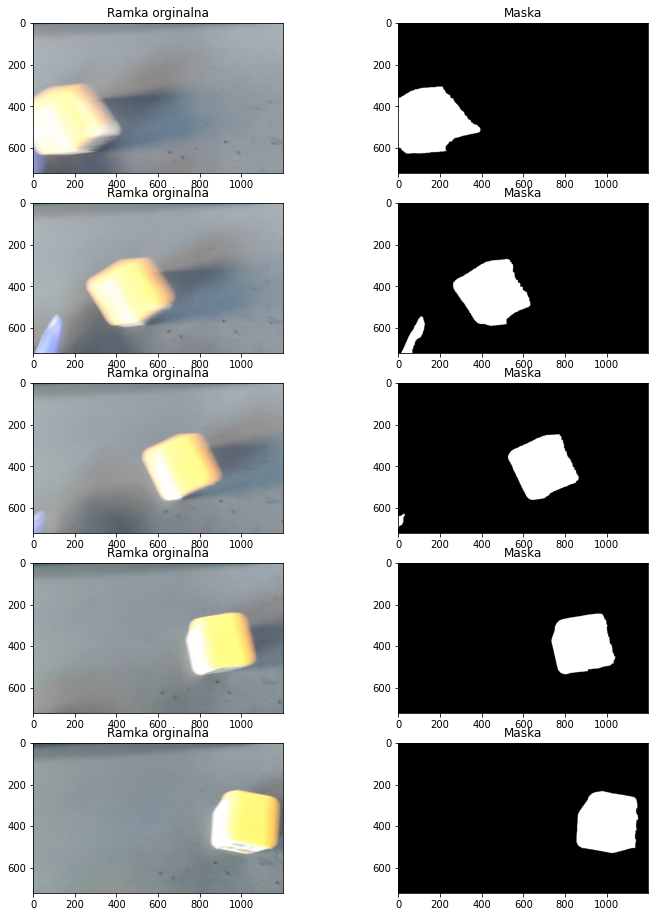

In [19]:
def main():
    
    cap = cv.VideoCapture("sample1.mp4")                                        # Pobieranie obrazu z pliku bądź kamery
    if not cap.isOpened():
        print("Cannot open camera")
        exit()
    else:
        iter = 0
        lst_bound = []                                                          # Lista przechowująca ramki obrazu do wyznaczania histogramu
        lst_mask = []                                                           # Liczta zawierające maskę binarną ramki do wyznaczenia histogramu
        size = (1200, 720)                                                      # Wymiar ramki przetwarzanego obrazu

        ret, frame = cap.read()                                                 # Pobieranie ramki obrazu
        if not ret:                                                             # Sprawdzania czy odczytano ramkę obrazu poprawnie, jeżeli tak to ret == True
            print("Can't receive frame (stream end?). Exiting ...")
        else:
            # Pobieranie ramki z tłem                                  
            base =cv.resize(frame,size)                                         # Tło o zminionym rozmiarze
            gray_base = cv.cvtColor(base, cv.COLOR_BGR2GRAY)                    # Konwersja do barw odcieni szarości

# --------------- Główna pętla programu ---------------------------------------
            while True:
                # Pobieranie obecnie przetwarzanej ramki obrazu
                ret, frame = cap.read()
                if not ret:                                                     # Sprawdzania czy odczytano ramkę obrazu poprawnie, jeżeli tak to ret == True
                    print("Can't receive frame (stream end?). Exiting ...")
                    break
                # Zmiana rozmiaru ramki obrazu oraz konwersja to barw w skali szarości         
                frame =cv.resize(frame, size)                                   
                gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

                # Różnica obrazu obecnie przetwarzanego z tłem oraz binaryzacja
                diff = cv.subtract(gray_frame, gray_base)
                threshold = 45
                binary = np.uint8(diff > threshold) * 255

                # Operacje morfologiczne - dylatacja i erozja
                kernel = np.ones((5, 5), np.uint8)
                dilated_mask = cv.dilate(binary, kernel, iterations=3)
                mask = cv.erode(dilated_mask, kernel, iterations=5)

                # Klasyfikator do wykrywania obiektu pojawiającego się na obrazie
                SAD_classificator = np.sum(mask) /(size[0]*size[1])

                # Wyświetlanie wartości klasyfikatora aby dobrać odpowiedni próg:
                # print(f'SAD value: {SAD_classificator}')

                # Decyzja o momencie wyliczania histogramów - czyli obiekt pojawił się na obrazie - decyduje o tym SAD
                if SAD_classificator > 20:
                    # TO DO: Wyliczenie histogramu, porównanie i klasyfikacja obiektu, komunikacja
                    iter += 1
                    if iter <= 10:
                        lst_bound.append(cp.copy(frame))
                        lst_mask.append(cp.copy(mask))

                # Próbne wyświetlanie obrazu:
                # cv.imshow('BINARY', mask)

                # Rysowanie boundingboxów na obrazie:
                draw_countur(mask, frame)

                # Zakończenie działania programu:
                if cv.waitKey(1) == ord('q'):
                    break

                # Do odczytywania video z pliku, jeśli z kamery to zakomentować linijkę poniżej
                time.sleep(0.03)

# --------------- Koniec głównej pętli programu -------------------------------

        # Niszczenie okien do wyświetlania obrazu oraz jego pobierania
        cv.waitKey(0)
        cv.destroyAllWindows()


    # Wyświetlanie zgromadzonych zdjęć do przetwarzania i wylicznia histogramu:
    plt.figure(figsize=(12,16))
    for i in range(len(lst_bound)):
        plt.subplot(5, 2, i+1)
        if i % 2 == 0:
            plt.imshow(lst_bound[i])
            plt.title('Ramka orginalna')
        else:
            plt.imshow(lst_mask[i-1], cmap='gray')
            plt.title("Maska")
    plt.show()
main()